In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [7]:
!pip install missingno

In [8]:
import pandas as pd
import cleaning_game_file as cgf

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [15]:
data = pd.read_csv('data/game_files.csv', sep=';', encoding="latin-1", low_memory = False)

df_obj = cgf.Cleaner(data)
df_obj.clean_data()

df = df_obj.data

## Goal for analysis

At this point, there are a fair number of columns to go through and analyze for the purpose of filling missing values. At this moment, I am looking to at least handle "estimated_ba_using_speedangle" (which is crucial for the next steps), "babip_value", and "bat_event". The pitching stats migh have to be handled while I look more in-depth into pitcher analysis. I will start with an overall analysis, to see how missing values line up, hoping to get further information on this, and in seeing if there is a pattern that emerges which contains information about the dataset. I will then look further into the areas I feel necessary to look into.

## Overall missing values

At this point, I have handled all columns that could be filled or corrected without further analysis. This includes pitcher and batter names, game_date correction, dropping deprecated and columns that will be unavailable/irrelevant, event separation and simplification, and simplification of baserunner data. I expect to remove baserunner data due to it being very at bat specific when the goal is to achieve a game-by-game prediction. Below, I have taken the remaining missing values and plotted their missing values against eachother.

In [16]:
cols = df.columns

missing_cols = []
not_missing_cols = []

for col in cols:
    if df[col].isna().sum() > 0:
        missing_cols.append(col)
    else:
        not_missing_cols.append(col)

<AxesSubplot:>

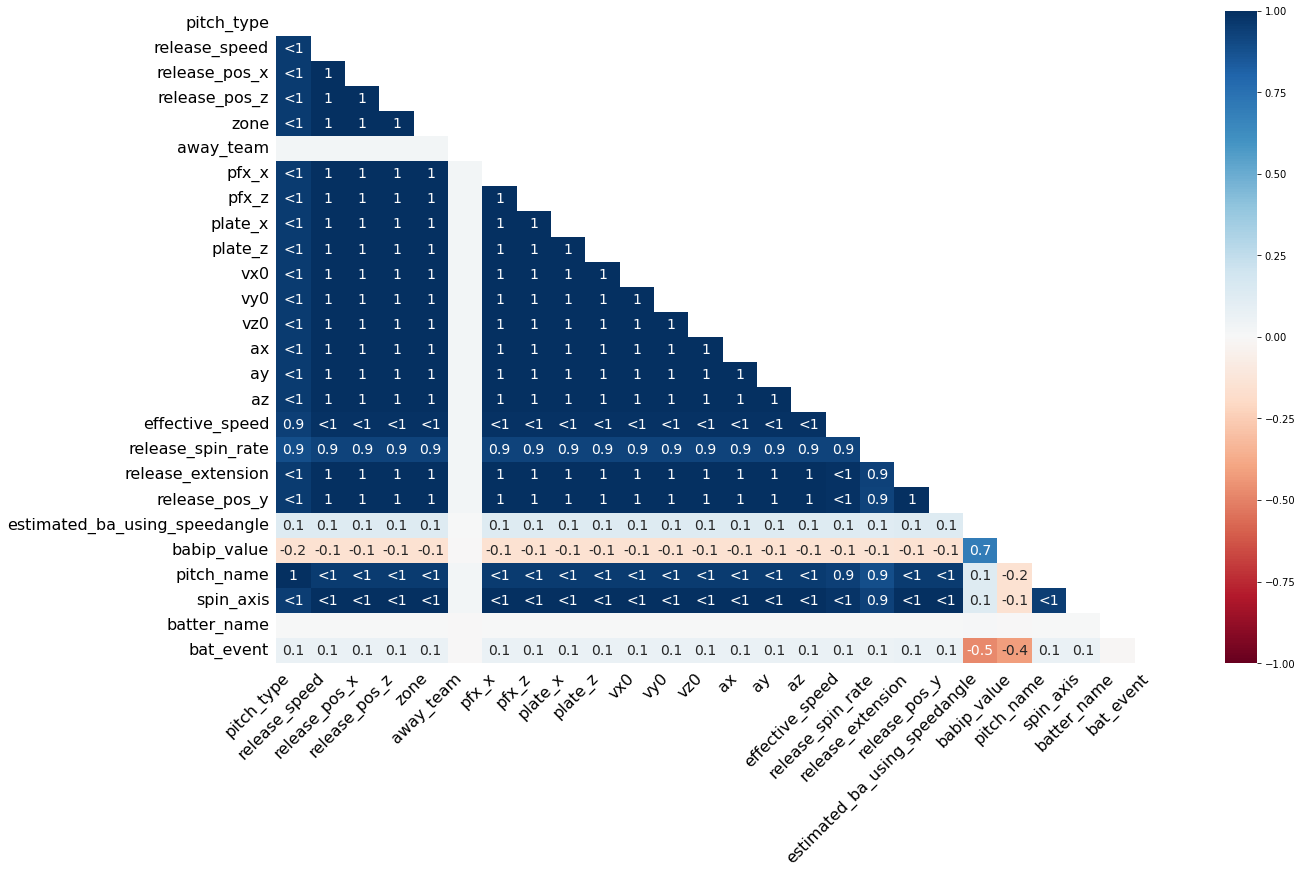

In [17]:
df_missing = df[missing_cols]

msno.heatmap(df_missing)

There is a large amount of overlap in missing values for pitches, which leads to some questions in terms of events tied to these missing values. These could be values in which there was some play that did not involve a pitch being thrown such as a pickoff attempt or pitchout. Otherwise, these values might require more analysis for strictly pitching. On the other end, "batter_name" has no overlap, but I intend to use mlb.com/player and web scraping to handle those missing values.

"away_team" is a field I am surprised to see missing values for. I will have to look directly at these entries to see why these are missing. Perhaps it is a data entry error.

"estimated_ba_using_speedangle" and "babip_value" should be able to be handled with further analysis. They appear to have little to no overlap with other missing values. While batting average on ball in play (babip) is an easily calculated metric, I hope to see some consistency in "estimated_ba_using_speedangle" in terms of events and/or some other metric.